In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

from allen_v1dd.client import OPhysClient
from allen_v1dd.duplicate_rois import get_duplicate_roi_pairs_in_session, get_unique_duplicate_rois, parse_duplicates_from_h5, save_duplicates_to_h5
from allen_v1dd.stimulus_analysis import analysis_tools as at

at.set_stylesheet()

%load_ext autoreload
%autoreload 2

In [47]:
counts_at_depth = pd.DataFrame(columns=["prev", "fixed"])
counts_at_depth.index.name = "depth"

vectors = {}
total_n_diff = {}

for filename, col in (("/Users/chase/Desktop/stimulus_analyses_v2_BAD_DUP_COUNTS.h5", "prev"), ("/Users/chase/Desktop/stimulus_analyses_v2.h5", "fixed")):
# for filename, col in (("/Users/chase/Desktop/stimulus_analyses_v1.h5", "prev"), ("/Users/chase/Desktop/stimulus_analyses_v2.h5", "fixed")):
    at.set_analysis_file(filename)
    for group in at.iter_plane_groups():
    # for group in at.iter_plane_groups(filter=dict(mouse=409828, column=1)):
        plane_id = f"{group.attrs['session_id']}_{group.attrs['plane']}"
        vector = group["is_roi_valid"][()] & group["is_ignored_duplicate"][()]

        if plane_id in vectors:
            v2 = vectors[plane_id]
            n_diff = np.sum(vector != v2)
            # k = f"{group.attrs['mouse']}_{group.attrs['column']}"
            k = group.attrs["mouse"]
            # k = group.attrs['plane_depth_microns']
            total_n_diff[k] = total_n_diff.get(k, 0) + n_diff

            if plane_id.startswith("M409828_1"):
                print(plane_id, n_diff)
        else:
            vectors[plane_id] = vector

        depth = group.attrs["plane_depth_microns"]
        n = group.attrs["n_rois_valid_ignoring_duplicates"]
        counts_at_depth.at[depth, col] = n

print("TOTAL DIFF", total_n_diff)
print(counts_at_depth.sum())
counts_at_depth

M409828_11_0 0
M409828_11_1 0
M409828_11_2 10
M409828_11_3 16
M409828_11_4 21
M409828_11_5 8
M409828_12_0 25
M409828_12_1 55
M409828_12_2 160
M409828_12_3 55
M409828_12_4 51
M409828_12_5 21
M409828_13_0 45
M409828_13_1 92
M409828_13_2 231
M409828_13_3 94
M409828_13_4 42
M409828_13_5 4
M409828_14_0 19
M409828_14_1 61
M409828_14_2 188
M409828_14_3 29
M409828_14_4 21
M409828_14_5 4
M409828_15_0 25
M409828_15_1 108
M409828_15_2 25
M409828_15_3 0
M409828_15_4 0
M409828_15_5 0
M409828_16_0 0
M409828_17_0 0
M409828_18_0 0
M409828_19_0 0
M409828_1a_0 0
M409828_1b_0 0
M409828_1c_0 0
M409828_1d_0 0
M409828_1e_0 0
M409828_1f_0 0
TOTAL DIFF {409828: 6050, 416296: 4209, 427836: 5076, 438833: 6695}
prev     5640
fixed    7123
dtype: object


,prev,fixed
depth,,
50,5,6
66,19,22
82,41,68
98,121,142
114,195,236
130,229,246
146,130,162
162,172,205
178,116,202


In [2]:
client = OPhysClient("chase")

In [3]:
session = client.load_ophys_session("M409828_13")

In [4]:
at.set_analysis_file("/Users/chase/Desktop/stimulus_analyses_v2.h5")

for session_group, _ in at.iter_plane_groups(filter=dict(mouse=session.get_mouse_id(), column=session.get_column_id(), volume=session.get_volume_id()), return_session_group=True):
    old_dups = parse_duplicates_from_h5(session_group)
    break

print(len(old_dups), "duplicates found in", session.get_session_id())

508 duplicates found in M409828_13


# Recompute best ROI based on the strongest dF/F trace

In [5]:
# Use high quantile as a proxy for trace strength
q = 0.995
trace_strength = {
    plane: session.get_traces(plane=plane, trace_type="dff").quantile(q, dim="time").values
    for plane in session.get_planes()
}

# Recompute the best ROI as the one with the strongest connection strength
dups = []
for dup_set in old_dups:
    dup_set = sorted(dup_set, key=lambda x: trace_strength[x[0]][x[1]], reverse=True) # copy and sort in descending order of trace strength
    
    # for plane, roi in dup_set:
    #     print(plane, roi, trace_strength[plane][roi])
    # break
    dups.append(dup_set)

<function matplotlib.pyplot.xlabel(xlabel, fontdict=None, labelpad=None, *, loc=None, **kwargs)>

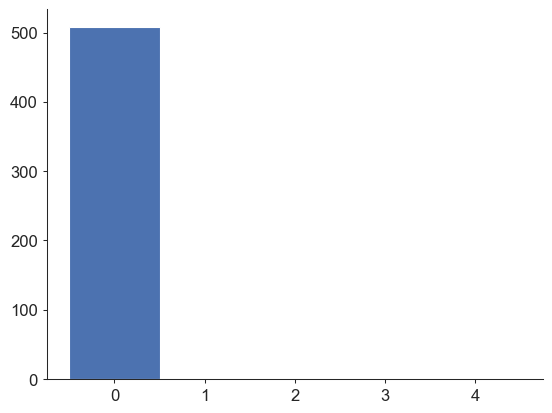

In [6]:
delta_plane = []

for old_dup_set, new_dup_set in zip(old_dups, dups):
    old_best, new_best = old_dup_set[0], new_dup_set[0]

    delta_plane.append(abs(new_best[0] - old_best[0]))

plt.hist(delta_plane, bins=np.array([0, 1, 2, 3, 4, 5])-0.5)
plt.xlabel

In [7]:
dups_of_size = {}

for dup_set in dups:
    n = len(dup_set)
    if n in dups_of_size:
        dups_of_size[n].append(dup_set)
    else:
        dups_of_size[n] = [dup_set]

for n in sorted(dups_of_size.keys()):
    d = len(dups_of_size[n])
    print(f"n = {n}: {d} ({d/len(dups)*100:.0f}%) duplicate groups")

n = 2: 339 (67%) duplicate groups
n = 3: 94 (19%) duplicate groups
n = 4: 39 (8%) duplicate groups
n = 5: 17 (3%) duplicate groups
n = 6: 19 (4%) duplicate groups


In [8]:
roi_to_best_plane = {} # (plane, roi) -> best_plane

for dup_set in dups:
    best_plane = dup_set[0][0]
    for roi in dup_set:
        roi_to_best_plane[roi] = best_plane

In [9]:
plane, roi = 1, 5
roi_mask = session.get_roi_image_mask(plane, roi)
y, x = np.mean(np.where(roi_mask), axis=1, dtype=int)
depth = session.get_plane_depth(plane)

print(x, y, depth)

197 185 258


# Examine falloff of trace strength for duplicate ROIs

[0.34926157 0.4151506  0.75170958 0.40914273 0.35158914]


Text(0.5, 0, 'Plane relative to ROI plane')

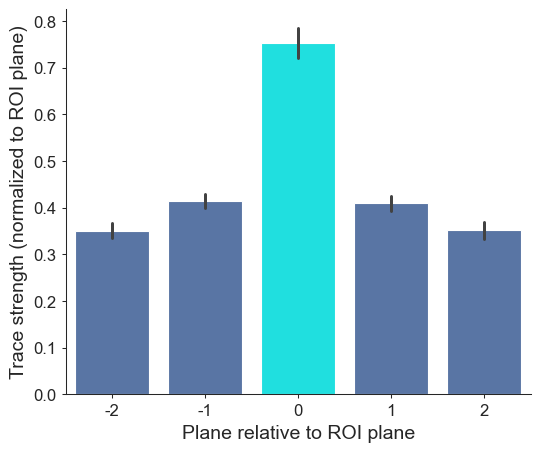

In [312]:
plane_span_width = 2
plane_strengths = np.full((len(dups), 2*plane_span_width+1), np.nan)

for i, dup_set in enumerate(dups):
    best_plane, best_roi = dup_set[0]

    for p, r in dup_set:
        if abs(p - best_plane) <= plane_span_width:
            plane_strengths[i, plane_span_width + best_plane - p] = trace_strength[p][r]

plane_strengths = plane_strengths# / plane_strengths[:, [plane_span_width]]
print(np.nanmean(plane_strengths, axis=0))

fig, ax = plt.subplots(figsize=(6, 5))
sns.barplot(plane_strengths, palette=["b", "b", "aqua", "b", "b"], ax=ax)
ax.set_ylabel("Trace strength (normalized to ROI plane)")
ax.set_xticklabels(range(-plane_span_width, plane_span_width+1))
ax.set_xlabel("Plane relative to ROI plane")

In [337]:
x = np.array(sorted(plane_strengths.tolist(), key=lambda x: np.nanmax([abs(x[1]-x[2]), abs(x[3]-x[2])])))

# (~np.isnan(x)).sum(axis=1)
((~np.isnan(x)).sum(axis=1) == 2)[:100].mean()

0.9

(array([48., 30., 29., 26., 27., 16., 17., 10.,  8., 15., 10., 12.,  8.,
        13., 11.,  9., 15.,  6.,  6.,  1.,  3.,  2.,  3.,  2.,  5.,  3.,
         0.,  1.,  1.]),
 array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
        0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  , 1.05,
        1.1 , 1.15, 1.2 , 1.25, 1.3 , 1.35, 1.4 , 1.45]),
 <BarContainer object of 29 artists>)

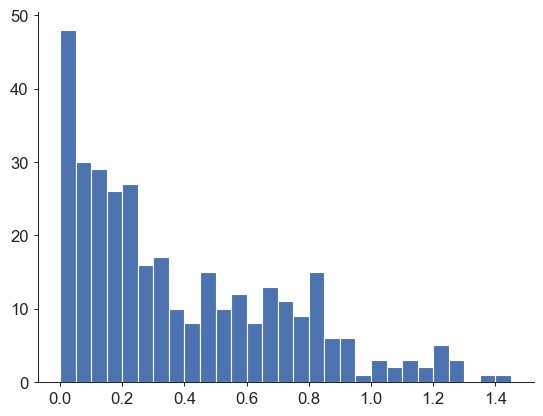

In [329]:
plt.hist(plane_strengths[:, 2] - plane_strengths[:, 1], bins=np.arange(0, 1.5, 0.05))

[0.79705818 0.932927   1.         0.91136206 0.84151512]


Text(0.5, 0, 'Plane relative to ROI plane')

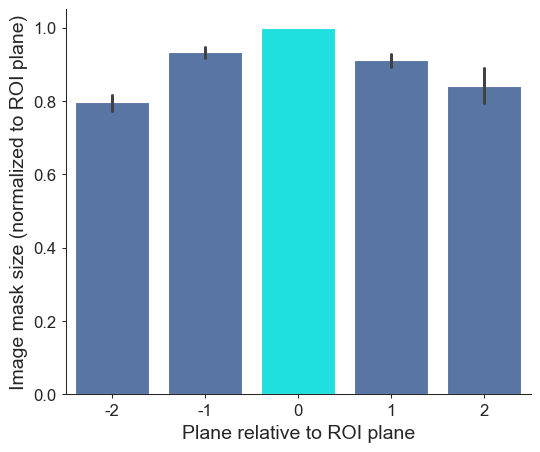

In [310]:
plane_span_width = 2
plane_strengths = np.full((len(dups), 2*plane_span_width+1), np.nan)

for i, dup_set in enumerate(dups):
    best_plane, best_roi = dup_set[0]

    for p, r in dup_set:
        if abs(p - best_plane) <= plane_span_width:
            plane_strengths[i, plane_span_width + best_plane - p] = np.sum(session.get_roi_image_mask(p, r))

plane_strengths = plane_strengths / plane_strengths[:, [plane_span_width]]
print(np.nanmean(plane_strengths, axis=0))

fig, ax = plt.subplots(figsize=(6, 5))
sns.barplot(plane_strengths, palette=["b", "b", "aqua", "b", "b"], ax=ax)
ax.set_ylabel("Image mask size (normalized to ROI plane)")
ax.set_xticklabels(range(-plane_span_width, plane_span_width+1))
ax.set_xlabel("Plane relative to ROI plane")

# Examine ROI positions of 6-plane duplicates

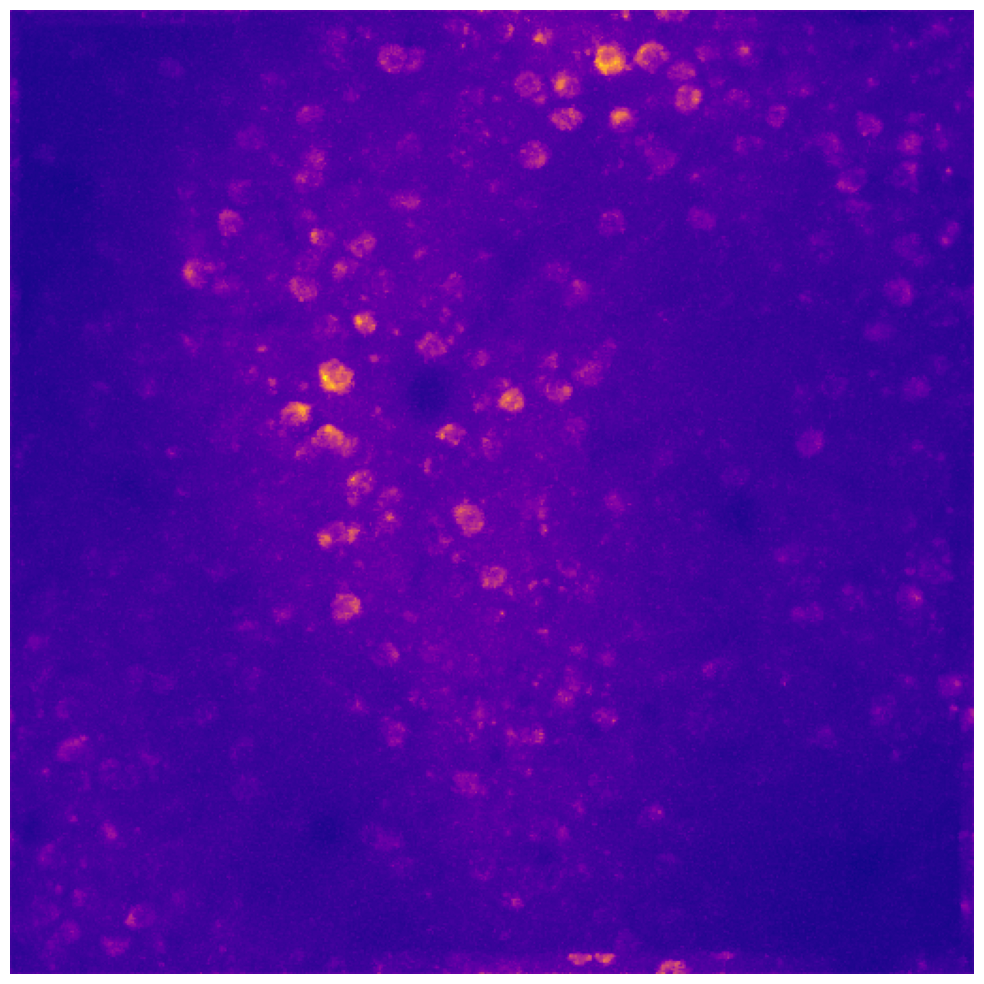

In [11]:
for plane in session.get_planes():
    proj_raw_mean, proj_raw_max, proj_de_mean, proj_de_max, proj_de_corr = session.get_plane_projection_images(plane)
    depth = session.get_plane_depth(plane)
    fig, ax = plt.subplots(figsize=(10, 10), tight_layout=True)

    ax.axis("off")
    ax.imshow(proj_raw_max, cmap="plasma")
    # ax.set_title(f"Plane {plane} ({depth} µm)")

    # for roi in np.where(session.is_roi_valid(plane))[0]:
    #     roi_mask = session.get_roi_image_mask(plane, roi)
    #     y, x = np.mean(np.where(roi_mask), axis=1)

    #     if (plane, roi) in roi_to_best_plane:
    #         # ROI has duplicates
    #         if roi_to_best_plane[(plane, roi)] == plane:
    #             # This is the kept ROI
    #             color = "lime"
    #         else:
    #             # This is an ignored ROI
    #             color = "red"
    #     else:
    #         # ROI doesn't have duplicates
    #         color = "white"

    #     ax.text(x, y, f"{roi}", color=color, ha="center", va="center", fontsize=8)

    fig.savefig(f"/Users/chase/Desktop/M409828_13_2p_proj_no_labels/Plane{plane}.png", dpi=150, bbox_inches="tight")
    
    if plane > 0:
        plt.close(fig)
        # break

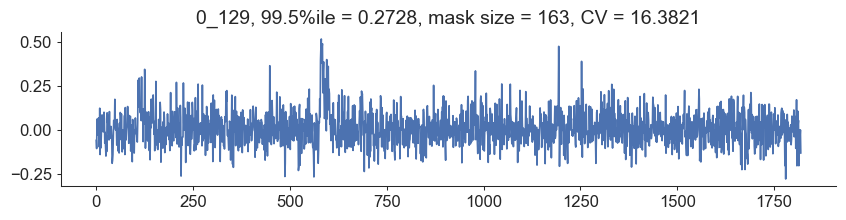

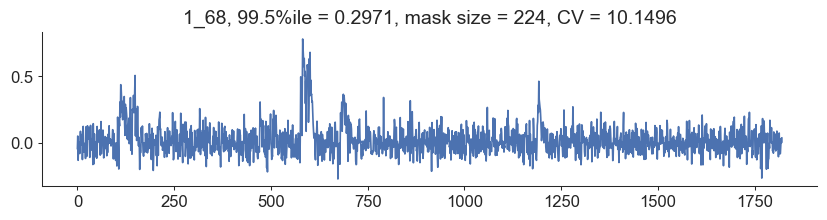

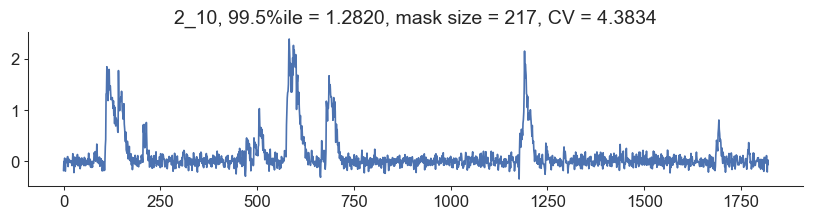

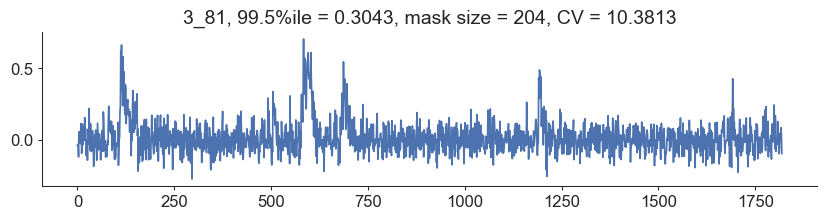

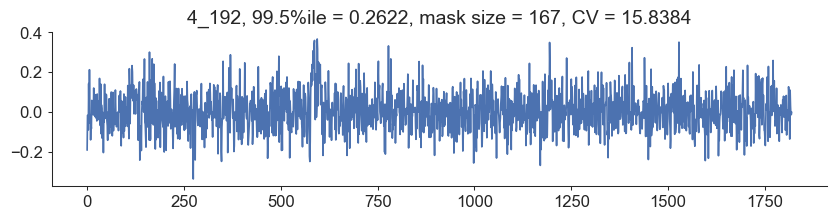

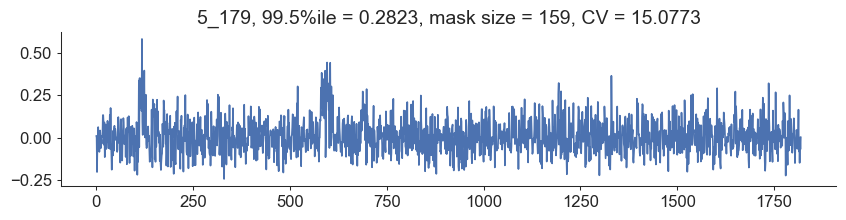

In [179]:
# for plane, roi in ((1, 27), (2, 11)):
for plane, roi in sorted(dups_of_size[6][2], key=lambda x: x[0]):
    plt.figure(figsize=(10, 2))
    all_traces = session.get_traces(plane=plane, trace_type="dff").sel(roi=roi)
    spont_traces = session.get_spont_traces(plane=plane, trace_type="dff").sel(roi=roi)
    plt.plot(spont_traces)
    # plt.plot(all_traces)
    mask_size = int(np.sum(session.get_roi_image_mask(plane, roi)))
    cv = np.std(all_traces) / np.mean(all_traces)
    plt.title(f"{plane}_{roi}, 99.5%ile = {np.quantile(all_traces, 0.99):.4f}, mask size = {mask_size}, CV = {cv:.4f}")

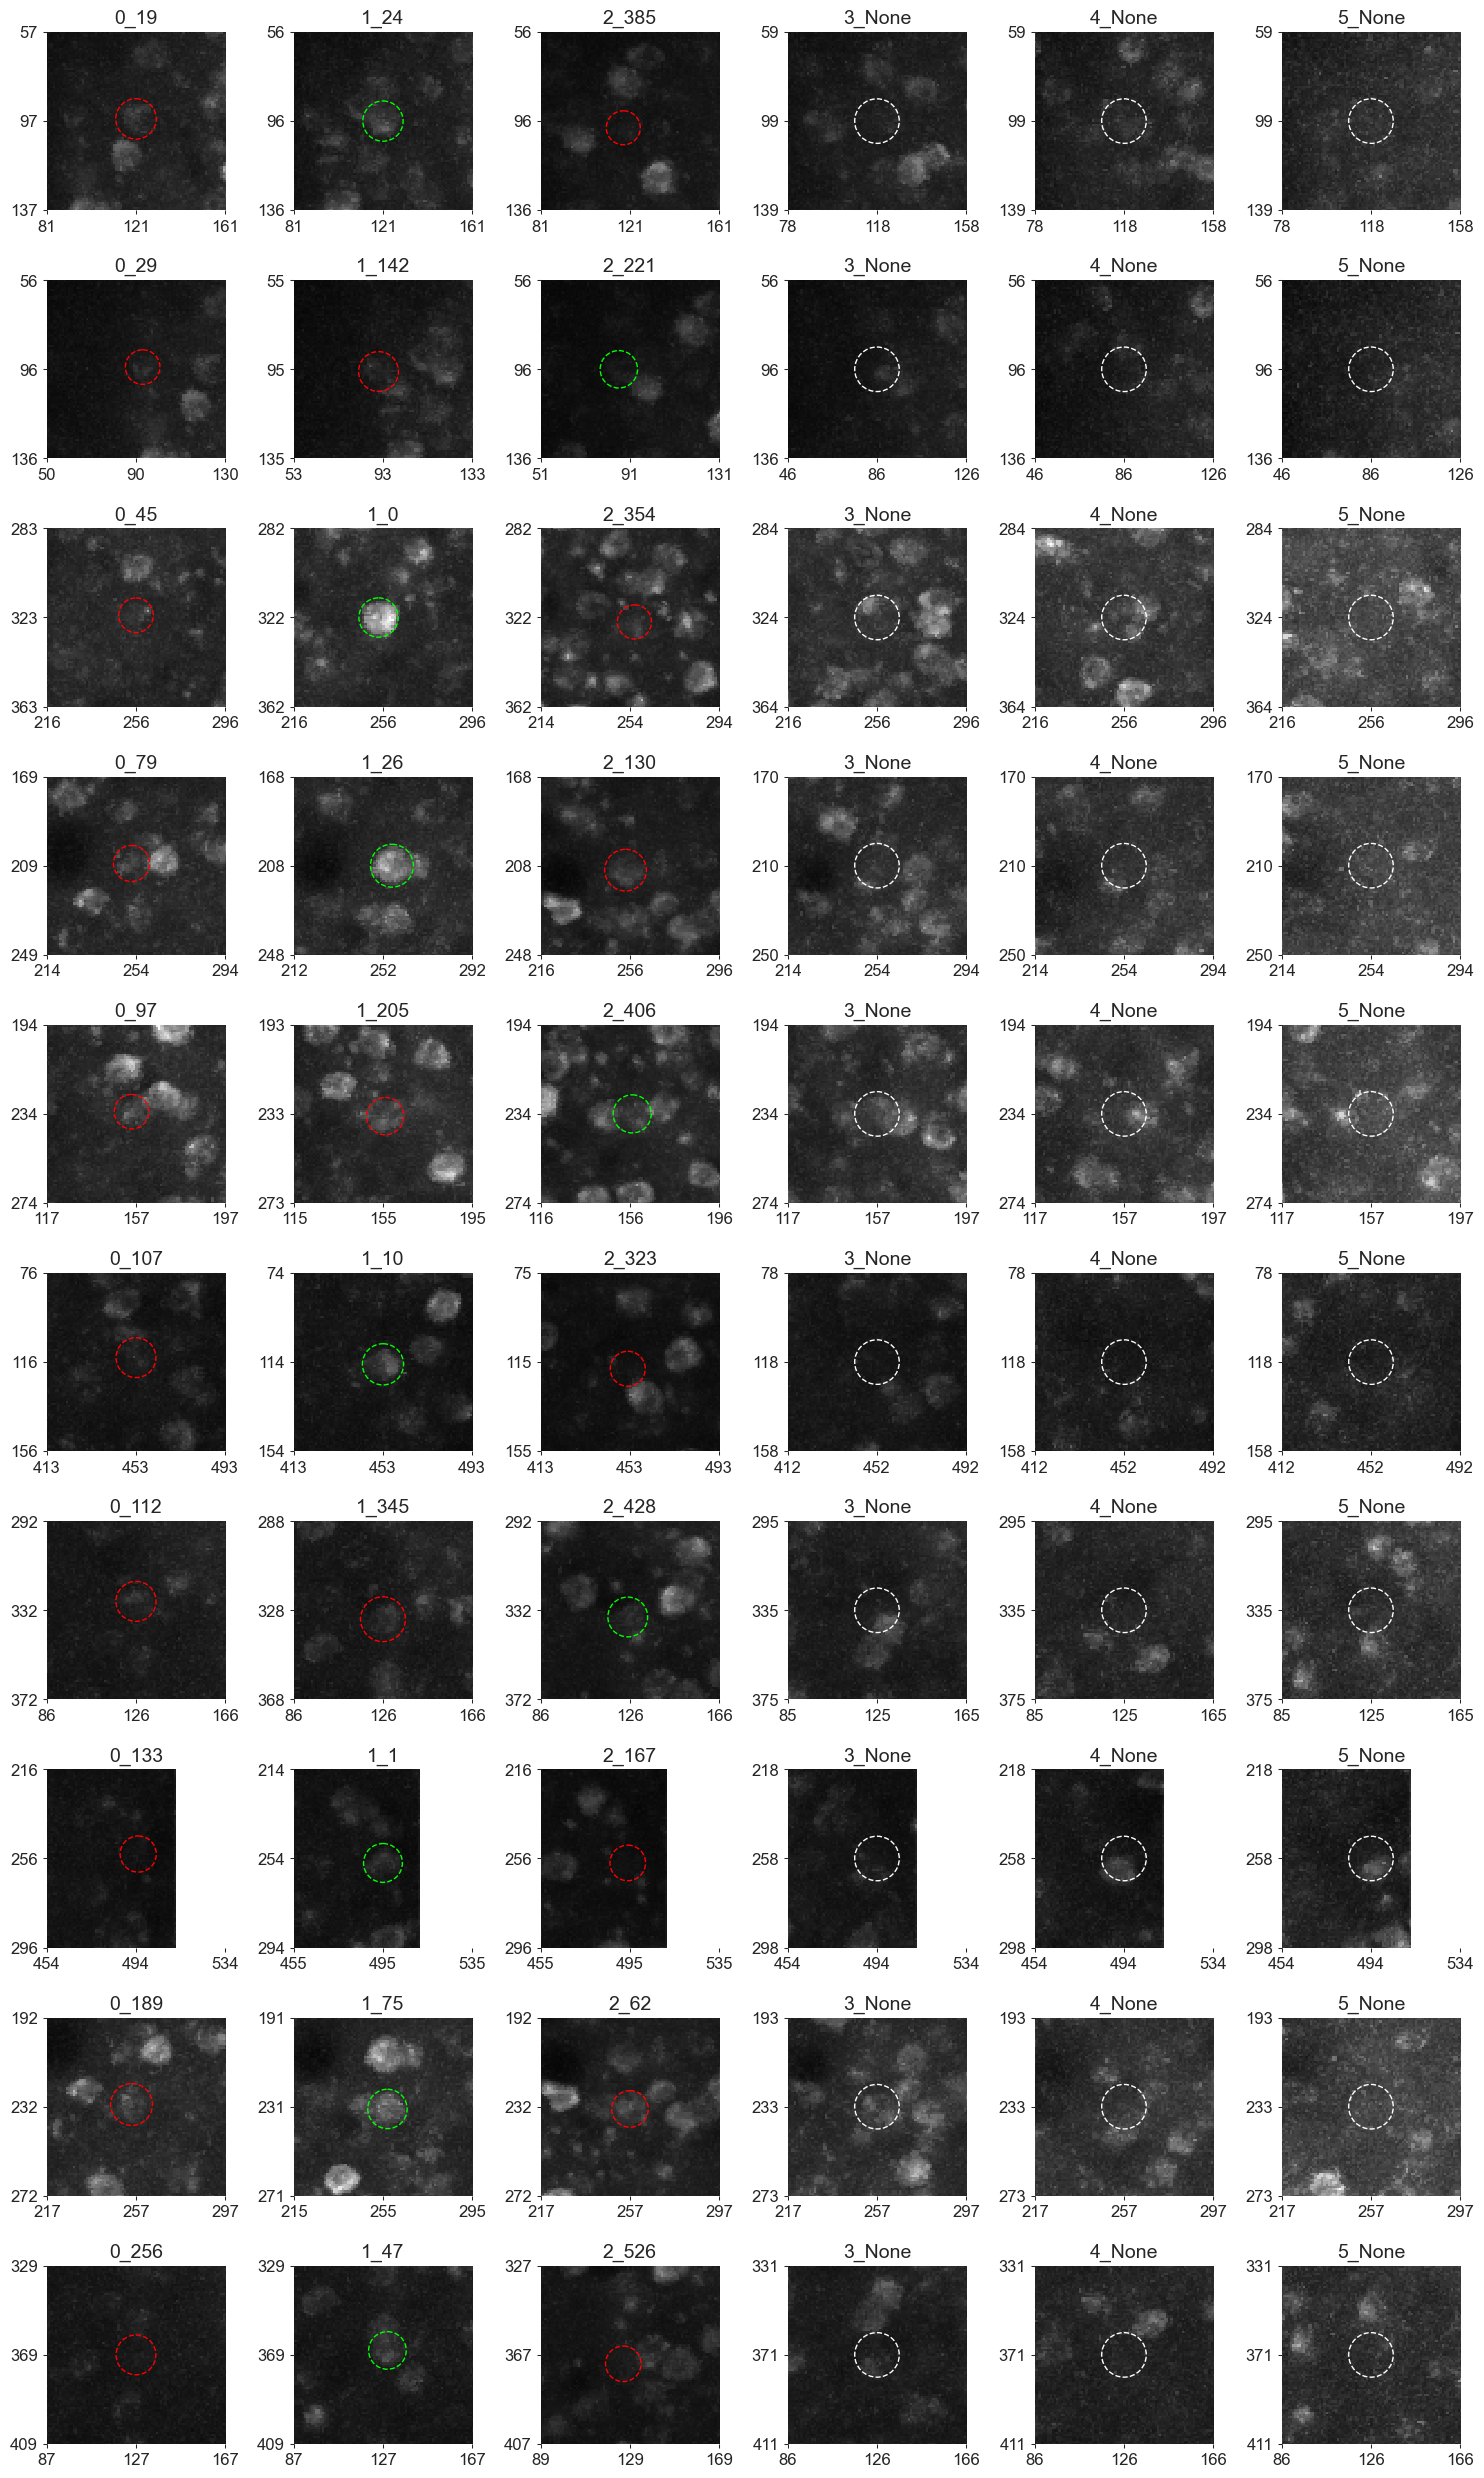

In [174]:
plane_proj_imgs = {}

for plane in session.get_planes():
    proj_raw_mean, proj_raw_max, proj_de_mean, proj_de_max, proj_de_corr = session.get_plane_projection_images(plane)
    plane_proj_imgs[plane] = proj_raw_max
    # plane_proj_imgs[plane] = proj_de_corr

img_rad = 40

for dup_set_size in [3]:
    nrows = min(10, len(dups_of_size[dup_set_size]))
    n_planes = 6
    # n_planes = dup_set_size
    fig, axs = plt.subplots(figsize=(n_planes*2.5, nrows*2.5), nrows=nrows, ncols=n_planes, tight_layout=True)

    for row in range(nrows):
        row_dups = dups_of_size[dup_set_size][row]
        # dup_set = sorted(dups_of_size[dup_set_size][row], key=lambda x: x[0]) # sort by plane
        dup_plane_to_roi = {}
        best_plane = row_dups[0][0]
        y = []
        x = []

        for plane, roi in row_dups:
            if plane in dup_plane_to_roi:
                print(f"WARN: duplicate plane for ROI {plane}-{roi}")
                continue
            dup_plane_to_roi[plane] = roi

            roi_mask = session.get_roi_image_mask(plane, roi)
            mask_size = int(np.sum(roi_mask))
            Y, X = np.median(np.where(roi_mask), axis=1)
            y.append(Y)
            x.append(X)
        
        y = int(np.mean(y))
        x = int(np.mean(x))

        for plane in range(n_planes):
            ax = axs[row, plane]
            roi = dup_plane_to_roi.get(plane)
            is_best_roi = plane == best_plane
            img = plane_proj_imgs[plane]#[y-fig_r:y+fig_r, x-fig_r:x+fig_r]
            ax_title = f"{plane}_{roi}"

            ax.set_title(ax_title)
            ax.imshow(img, cmap="gray", interpolation="nearest")
            ax.set_xlim(x-img_rad, x+img_rad)
            ax.set_ylim(y+img_rad, y-img_rad) # note y-axis is inverted

            # ax.axis("off")
            for spine in ax.spines: ax.spines[spine].set_visible(False)
            ax.set_xticks([x-img_rad, x, x+img_rad])
            ax.set_yticks([y+img_rad, y, y-img_rad])

            if roi is not None:
                roi_mask = session.get_roi_image_mask(plane, roi)
                mask_size = int(np.sum(roi_mask))
                y, x = np.mean(np.where(roi_mask), axis=1)
                y = int(y)
                x = int(x)
                # ax.imshow(roi_mask, cmap="gray", interpolation="nearest", alpha=0.25)
                # ax.scatter(x, y, color=("green" if is_best_roi else "red"))
                roi_radius = np.sqrt(mask_size / np.pi) * 1.1
                ax.add_patch(mpl.patches.Circle((x, y), roi_radius, fill=False, edgecolor=("lime" if is_best_roi else "red"), linestyle="dashed", linewidth=1))
                # ax.plot(x, y, "o", ms=roi_radius*2, mec='b', mfc='none', mew=2)
            else:
                ax.add_patch(mpl.patches.Circle((x, y), 10, fill=False, edgecolor="white", linestyle="dashed", linewidth=1))

# Load duplicate information from H5 files and save to CSV

In [417]:
# Load trace strengths and plane depths
session = client.load_ophys_session("M409828_13")
q = 0.995
roi_trace_strengths = {}
plane_depths = {}

for plane in session.get_planes():
    roi_trace_strengths[plane] = session.get_traces(plane=plane, trace_type="dff").quantile(q, dim="time").values
    plane_depths[plane] = session.get_plane_depth(plane)

# Load duplicates from H5
sess_filter = dict(mouse=409828, column=1, volume=3)
for session_group, _ in at.iter_plane_groups(filter=sess_filter, return_session_group=True):
    dups = parse_duplicates_from_h5(session_group)
    break

# Duplicate preprocessing
dup_roi_to_best_roi = {} # (plane, roi) -> (best_plane, best_roi)
best_dup_roi_to_other_planes = {} # (best_plane, best_roi) -> [plane1, plane2, ...]
best_dup_roi_to_weighted_depth = {} # (best_plane, best_roi) -> weighted_depth

for dup_set in dups:
    best = dup_set[0]
    best_dup_roi_to_other_planes[best] = [x[0] for x in dup_set[1:]]

    weighted_depth = 0
    total_weight = 0

    for i, dup in enumerate(dup_set):
        if i > 0:
            dup_roi_to_best_roi[dup] = best
        
        # if abs(dup[0] - best[0]) <= 1:
        trace_strength = roi_trace_strengths[dup[0]][dup[1]]
        weighted_depth += plane_depths[dup[0]] * trace_strength
        total_weight += trace_strength
    
    best_dup_roi_to_weighted_depth[best] = weighted_depth / total_weight

(array([  5.,   2., 146.,  51.,  51., 130.,  95.,  18.,   8.,   2.]),
 array([-15.91404711, -12.11046303,  -8.30687894,  -4.50329486,
         -0.69971077,   3.10387331,   6.9074574 ,  10.71104149,
         14.51462557,  18.31820966,  22.12179374]),
 <BarContainer object of 10 artists>)

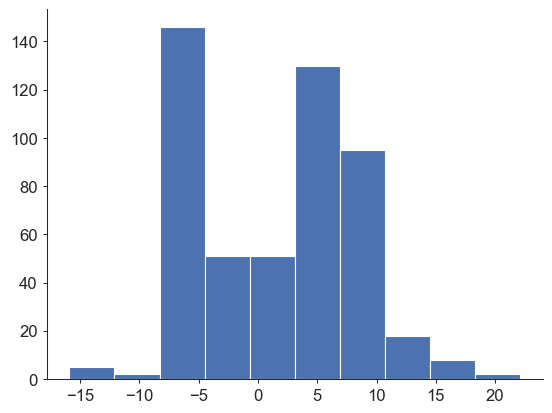

In [418]:
weighted_depths = []
real_depths = []
depth_diff = []

for (plane, roi), weighted_depth in best_dup_roi_to_weighted_depth.items():
    depth = plane_depths[plane]

    weighted_depths.append(weighted_depth)
    real_depths.append(depth)
    depth_diff.append(weighted_depth - depth)

plt.hist(depth_diff)

In [419]:
roi_df = pd.DataFrame(columns=["plane", "roi", "n_other_duplicates", "has_dup_below", "has_dup_above", "depth", "weighted_depth", "depth_min", "depth_max"])

depth_tol = 8

for group in at.iter_plane_groups(filter=sess_filter):
    plane = group.attrs["plane"]
    plane_depth = group.attrs["plane_depth_microns"]
    plane_rois = []

    for roi in np.where(group["is_roi_valid"][()])[0]:
        pr = (plane, roi)
        if pr not in dup_roi_to_best_roi: # If it is either not a duplicate or is the best duplicate
            plane_rois.append(roi)

    for roi in plane_rois:
        pr = (plane, roi)
        other_planes = best_dup_roi_to_other_planes.get(pr, [])
        n_other_duplicates = len(other_planes)
        weighted_depth = best_dup_roi_to_weighted_depth.get(pr, plane_depth)

        # Compute depth range
        has_dup_below = plane-1 in other_planes
        has_dup_above = plane+1 in other_planes

        if n_other_duplicates == 0:
            depth_min = plane_depth - depth_tol
            depth_max = plane_depth + depth_tol
        elif has_dup_below and has_dup_above:
            # Probably somewhere around the middle plane
            depth_min = plane_depth - 16
            depth_max = plane_depth + 16
        elif has_dup_below:
            # Probably somewhere between this plane and plane above
            depth_min = plane_depth - 16 - depth_tol
            depth_max = plane_depth + depth_tol
        elif has_dup_above:
            # Probably somewhere between this plane and plane below
            depth_min = plane_depth - depth_tol
            depth_max = plane_depth + 16 + depth_tol        

        roi_df.loc[len(roi_df)] = (plane, roi, n_other_duplicates, has_dup_below, has_dup_above, plane_depth, weighted_depth, depth_min, depth_max)

roi_df.to_csv("/Users/chase/Desktop/v1dd_M409828_13_roi_depths.csv", index=False)

roi_df

,plane,roi,n_other_duplicates,has_dup_below,has_dup_above,depth,weighted_depth,depth_min,depth_max
0,0,0,1,False,True,242,245.361559,234,266
1,0,1,1,False,True,242,246.476536,234,266
2,0,2,0,False,False,242,242.000000,234,250
3,0,3,1,False,True,242,247.898773,234,266
4,0,4,0,False,False,242,242.000000,234,250
...,...,...,...,...,...,...,...,...,...
1896,5,706,0,False,False,322,322.000000,314,330
1897,5,722,0,False,False,322,322.000000,314,330
1898,5,723,0,False,False,322,322.000000,314,330
1899,5,776,0,False,False,322,322.000000,314,330
